In [1]:
# 读入Fluit数据集 import
import os 
import os.path 
import numpy as np
from d2l import torch as d2l 

base_path="/home/suzhang/dataset/FluidDataset/"

In [2]:
# 导入基础的三种台阶高,及对应路径
Paths={}
heights=np.array(range(1,4),dtype=np.float32)*0.05
for i in range(0,3):
    Paths[str(heights[i])]=base_path+str(heights[i])+"/"
Paths

{'0.05': '/home/suzhang/dataset/FluidDataset/0.05/',
 '0.1': '/home/suzhang/dataset/FluidDataset/0.1/',
 '0.15': '/home/suzhang/dataset/FluidDataset/0.15/'}

In [3]:
# 对特定路径导入全部数据到数组
Datas={}

def DataLoaderFromFiles(path="../../dataset/FluidDataset/0.05/", height=0.05, set_type="training", vars_type="input", speed_add_flag=False, SpeedList=[]):
    filepath=path+set_type+"_set/"+vars_type+"/"
    filelists=os.listdir(filepath)
    for filename in filelists:
        txt_data=np.loadtxt(filepath+filename)
        if speed_add_flag:
            SpeedList.append(filename[:-4])
        Datas[str(height)+"."+set_type+"."+vars_type+"."+filename[:-4]]=(height,vars_type,float(filename[:-4]),txt_data)
            

In [4]:
# 导入全部数据
vars_types=["input","input2","input3","k","p","u","uv","v","epsilon"]
set_types=["training","development","test"]
SpeedListDict={}
for height in heights:
    for set_type in set_types:
        SpeedList=[]
        for vars_type in vars_types:
            speed_add_flag=False
            # 只进行一次速度加列表
            if vars_type == vars_types[0]:
                speed_add_flag=True
            DataLoaderFromFiles(Paths[str(height)],height,set_type,vars_type,speed_add_flag,SpeedList)
        SpeedListDict[str(height)+"."+set_type]=SpeedList


In [5]:
# 大小(60,250)
# 输入(_,3,60,250)
# 输出(_,6,60,250)
# 模型架构
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
import matplotlib.pyplot as plt

In [6]:
class Reshape(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self,X):
        return X.reshape(-1,3,60,250)

# 模型架构
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.reshape = Reshape()
        self.conv0 = nn.Conv2d(3, 6, 1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(6, 12, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,padding=1, return_indices=True)
        self.conv2 = nn.Conv2d(12, 24, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2,padding=1, return_indices=True)
        self.conv3 = nn.Conv2d(24, 48, 3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.conv4 = nn.Conv2d(48, 96, 3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.unpool4 = nn.MaxUnpool2d(kernel_size=2,stride=2)
        self.deconv4 = nn.ConvTranspose2d(96, 48, 3, stride=1,padding=1, output_padding=0)
        self.unpool3 = nn.MaxUnpool2d(kernel_size=2,stride=2)
        self.deconv3 = nn.ConvTranspose2d(48,24,3,stride=1,padding=1,output_padding=0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2,stride=2)
        self.deconv2 = nn.ConvTranspose2d(24,12,3,stride=1,padding=1,output_padding=(0,0))
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2,stride=2,padding=1)
        self.deconv1 = nn.ConvTranspose2d(12,6,3,stride=1,padding=1)
        
    def forward(self,X):
        self.reshape(X)
        X, indices1 = self.pool1(F.leaky_relu(self.conv1(self.conv0(X))))
        X, indices2 = self.pool2(F.leaky_relu(self.conv2(X)))
        X, indices3 = self.pool3(F.leaky_relu(self.conv3(X)))
        X, indices4 = self.pool4(F.leaky_relu(self.conv4(X)))

        X = self.unpool4(F.leaky_relu(X), indices4)
        X=self.deconv4(X)
        X = self.unpool3(F.leaky_relu(X), indices3)
        X=self.deconv3(X)
        X = self.unpool2(F.leaky_relu(X), indices2)
        X=self.deconv2(X)
        X=X[:,:,:31,:126]
        X = self.unpool1(F.leaky_relu(X), indices1)
        X=self.deconv1(X)
        return X
    
net=ConvNet()

In [7]:
# 损失函数
class NorMSEloss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,Y_hat,Y):
        Y_hat=Y_hat.reshape(-1,6,60*250)
        Y=Y.reshape(-1,6,60*250)
        Y_square_loss=torch.pow(Y_hat-Y,2)
        Y_normal_square=(torch.pow(Y_hat,2)+torch.pow(Y,2))/2
        Y_normal=Y_normal_square.sum(axis=2,keepdims=True)/(60*250)
        Y_loss=(Y_square_loss/Y_normal).mean()
        return Y_loss
                

In [8]:
def stackdata(data_list):
    """data_dict stacking"""
    X=np.stack(data_list[:3])
    Y=np.stack(data_list[3:])
    return (X,Y)

In [9]:
Datas

{'0.05.training.input.5.05': (0.05,
  'input',
  5.05,
  array([[5.05, 5.05, 5.05, ..., 5.05, 5.05, 5.05],
         [5.05, 5.05, 5.05, ..., 5.05, 5.05, 5.05],
         [5.05, 5.05, 5.05, ..., 5.05, 5.05, 5.05],
         ...,
         [0.  , 0.  , 0.  , ..., 5.05, 5.05, 5.05],
         [0.  , 0.  , 0.  , ..., 5.05, 5.05, 5.05],
         [0.  , 0.  , 0.  , ..., 5.05, 5.05, 5.05]])),
 '0.05.training.input.8.99': (0.05,
  'input',
  8.99,
  array([[8.99, 8.99, 8.99, ..., 8.99, 8.99, 8.99],
         [8.99, 8.99, 8.99, ..., 8.99, 8.99, 8.99],
         [8.99, 8.99, 8.99, ..., 8.99, 8.99, 8.99],
         ...,
         [0.  , 0.  , 0.  , ..., 8.99, 8.99, 8.99],
         [0.  , 0.  , 0.  , ..., 8.99, 8.99, 8.99],
         [0.  , 0.  , 0.  , ..., 8.99, 8.99, 8.99]])),
 '0.05.training.input.13.82': (0.05,
  'input',
  13.82,
  array([[13.82, 13.82, 13.82, ..., 13.82, 13.82, 13.82],
         [13.82, 13.82, 13.82, ..., 13.82, 13.82, 13.82],
         [13.82, 13.82, 13.82, ..., 13.82, 13.82, 13.82],
 

/home/suzhang/anaconda3/envs/ogb/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  if __name__ == "__main__":


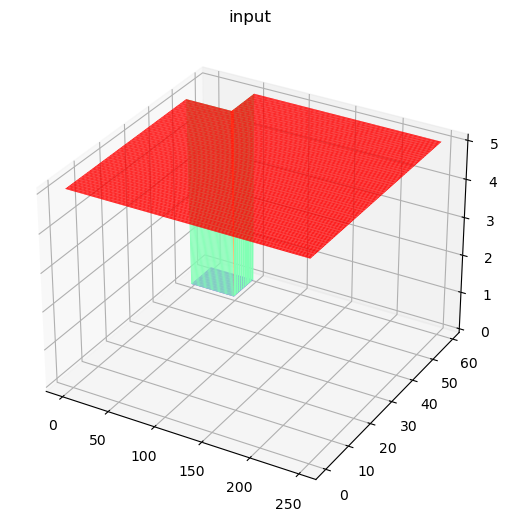

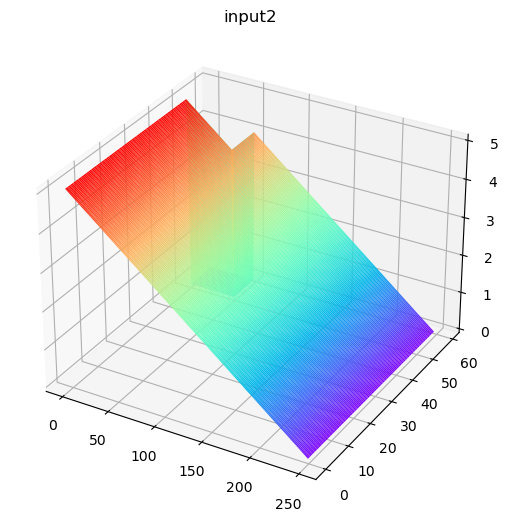

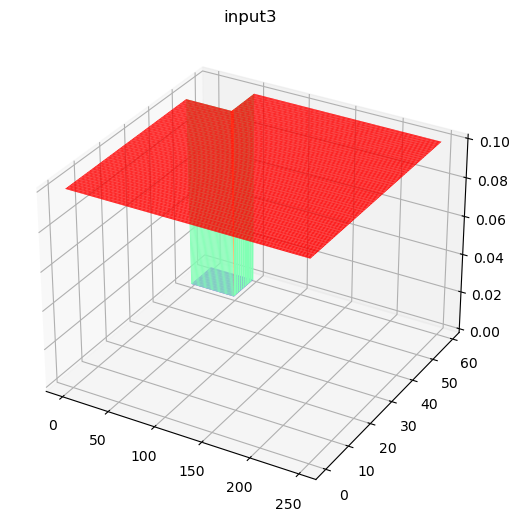

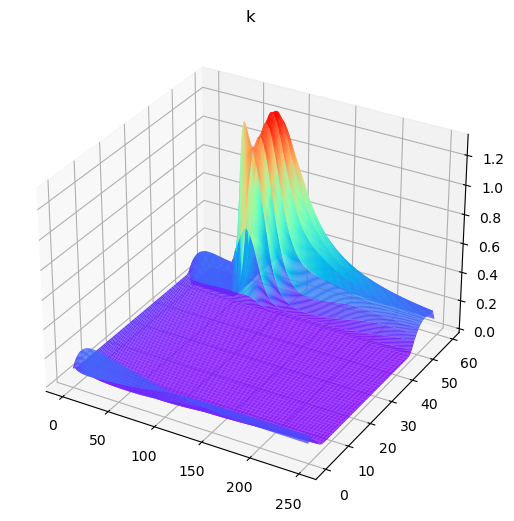

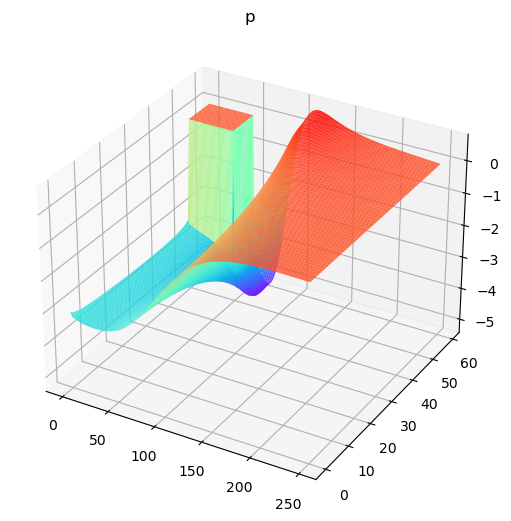

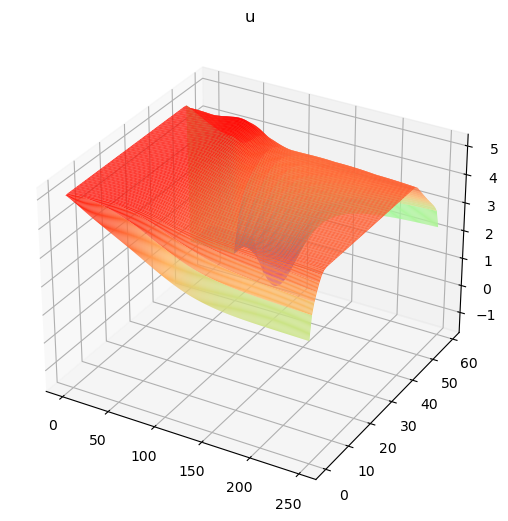

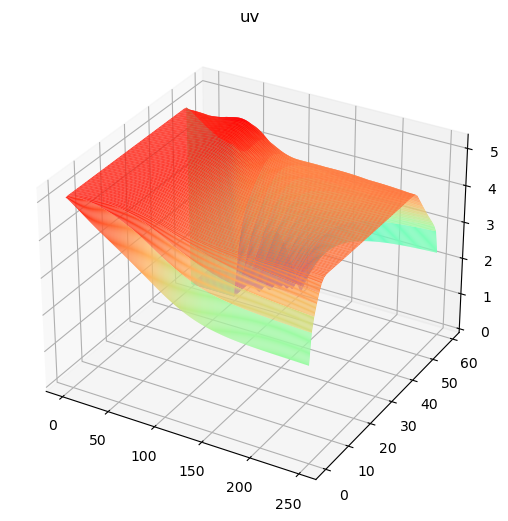

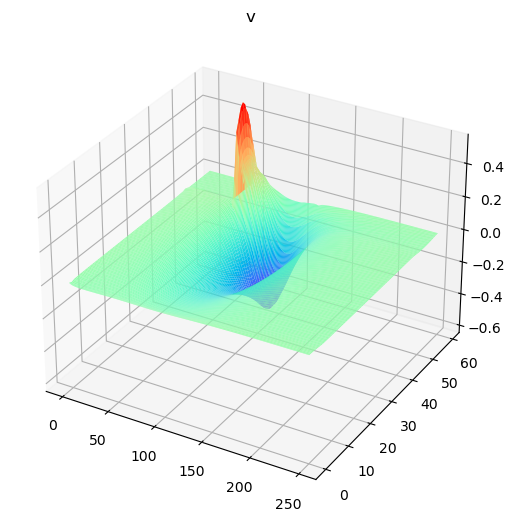

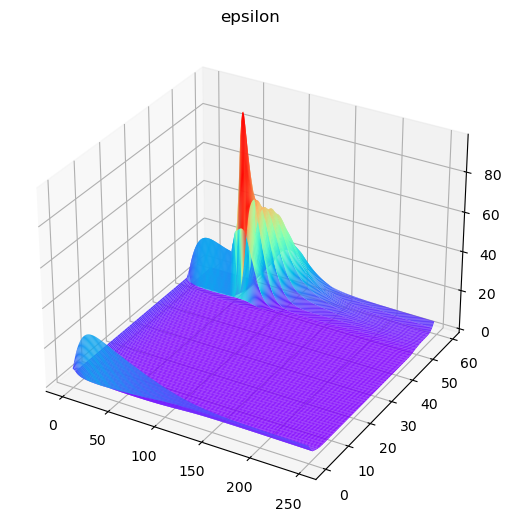

In [10]:
# 对一个数据进行可视化
X=np.arange(250)
Y=np.arange(60)
X,Y=np.meshgrid(X,Y)
from mpl_toolkits.mplot3d import Axes3D
for var in vars_types:
    Z=np.array(Datas["0.05.training."+var+".5.05"][3])
    fig = plt.figure(num=1)
    ax = Axes3D(fig)
    ax.set_title(var)
    ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.get_cmap('rainbow'))
    #ax.contourf(X,Y,Z,zdir='z',offset=-2,cmap='rainbow')
    plt.show()

In [11]:
class MyDataset(data.Dataset):
    def __init__(self,data_list) -> None:
        super().__init__()
        self.data_list=data_list
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,index):
        return self.data_list[index]

ModuleDatasets={}
for height in heights:
    for set_type in set_types:
        list = []
        SpeedList = SpeedListDict[str(height)+"."+set_type]
        for speed in SpeedList:
            X, Y = stackdata([Datas[str(height)+"."+set_type+"."+vars_type+"."+speed][3]for vars_type in vars_types])
            X = torch.tensor(X, dtype=torch.float32)
            Y = torch.tensor(Y, dtype=torch.float32)
            list.append((X, Y))
        ModuleDatasets[str(height)+"."+set_type]=MyDataset(list)

In [12]:
def evaluate_loss(net, data_iter, loss,device=torch.device("cpu")):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        X,y=X.to(device),y.to(device)
        out = net(X)
        y = d2l.reshape(y, out.shape)
        l = loss(out, y)
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [19]:
def train_model(net,train_dataset,develop_dataset,test_dataset,num_epochs,lr,devices,batch_size):
    """GPU Model"""
    # 初始化
    def init_weight(m):
        if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
            nn.init.xavier_normal_(m.weight)
    
    # GPU & 定义
    #print("The model is training on",device)
    #net.to(device)
    
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    loss=NorMSEloss()
    net=nn.DataParallel(net,devices)
    animator = d2l.Animator(
        xlabel="epoch", xlim=[1, num_epochs],
        legend=["train loss","deve loss", "test loss"]
    )
    timer = d2l.Timer()
    # 训练
    for epoch in range(num_epochs):
        # 改成训练模式
        net.train()
        metric = d2l.Accumulator(2)
        train_iter = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
        develop_iter = data.DataLoader(
            develop_dataset, batch_size=batch_size, shuffle=True)
        test_iter = data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=True)
        num_batches = len(train_iter)
        for X, y in train_iter:
            optimizer.zero_grad()
            X,y=X.to(devices[0]),y.to(devices[0])
            #net.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], X.shape[0])
            timer.stop()
            #if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        train_l = metric[0]/metric[1]
        deve_l=evaluate_loss(net,develop_iter,loss,device=devices[0])
        test_l=evaluate_loss(net,test_iter,loss,device=devices[0])
        if(epoch%5==0):
            animator.add(epoch + 1, (train_l,None,None))
            animator.add(epoch + 1, (None, deve_l, None))
            animator.add(epoch + 1, (None, None, test_l))
            print(f'train loss {train_l:.9f}, deve loss {deve_l:.9f}, '
                f'test loss {test_l:.9f}')
            print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
                f'on {str(devices)}')
        

    
    

train loss 0.470, deve loss 0.467, test loss 0.468
16.6 examples/sec on cuda:1
1


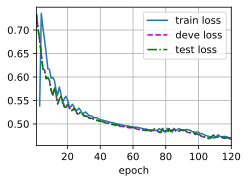

In [ ]:
# 1层模型
# 1层conv 1层deconv
train_model(net,ModuleDatasets["0.1.training"],ModuleDatasets["0.1.development"],ModuleDatasets["0.1.test"],120,0.01,torch.device("cuda:1"),batch_size=900)
    

train loss 0.592, deve loss 0.591, test loss 0.592
16.0 examples/sec on cuda:1
1


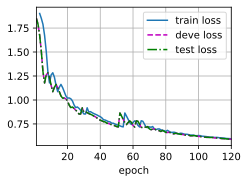

In [ ]:
# 2层模型
# 2层Conv 2层DeConv
train_model(net,ModuleDatasets["0.1.training"],ModuleDatasets["0.1.development"],ModuleDatasets["0.1.test"],120,0.01,torch.device("cuda:1"),batch_size=900)

train loss 0.437, deve loss 0.437, test loss 0.438
3.8 examples/sec on cuda:1
1


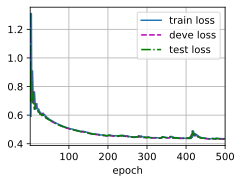

In [ ]:
# 加长训练epoch
train_model(net,ModuleDatasets["0.1.training"],ModuleDatasets["0.1.development"],ModuleDatasets["0.1.test"],500,0.01,torch.device("cuda:1"),batch_size=900)

In [ ]:
class Reshape(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self,X):
        return X.reshape(-1,3,60,250)

# 模型架构
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.reshape = Reshape()
        self.conv0 = nn.Conv2d(3, 6, 1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(6, 12, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,padding=1, return_indices=True)
        self.conv2 = nn.Conv2d(12, 24, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2,padding=1, return_indices=True)
        self.conv3 = nn.Conv2d(24, 48, 3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        #self.conv4 = nn.Conv2d(48, 96, 3, stride=1, padding=1)
        #self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        #self.unpool4 = nn.MaxUnpool2d(kernel_size=2,stride=2)
        #self.deconv4 = nn.ConvTranspose2d(96, 48, 3, stride=1,padding=1, output_padding=0)
        self.unpool3 = nn.MaxUnpool2d(kernel_size=2,stride=2)
        self.deconv3 = nn.ConvTranspose2d(48,24,3,stride=1,padding=1,output_padding=0)
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2,stride=2)
        self.deconv2 = nn.ConvTranspose2d(24,12,3,stride=1,padding=1,output_padding=(0,0))
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2,stride=2,padding=1)
        self.deconv1 = nn.ConvTranspose2d(12,6,3,stride=1,padding=1)
        
    def forward(self,X):
        self.reshape(X)
        X, indices1 = self.pool1(F.leaky_relu(self.conv1(self.conv0(X))))
        X, indices2 = self.pool2(F.leaky_relu(self.conv2(X)))
        X, indices3 = self.pool3(F.leaky_relu(self.conv3(X)))
        #X, indices4 = self.pool4(F.leaky_relu(self.conv4(X)))

        #X = self.unpool4(F.leaky_relu(X), indices4)
        #X=self.deconv4(X)
        X = self.unpool3(F.leaky_relu(X), indices3)
        X=self.deconv3(X)
        X = self.unpool2(F.leaky_relu(X), indices2)
        X=self.deconv2(X)
        X=X[:,:,:31,:126]
        X = self.unpool1(F.leaky_relu(X), indices1)
        X=self.deconv1(X)
        return X
    
net=ConvNet()

train loss 0.341, deve loss 0.409, test loss 0.410
8.9 examples/sec on cuda:1
1


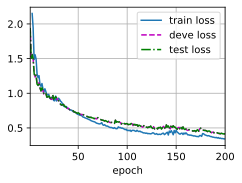

In [ ]:
# 3层模型
# 3层Conv 3层DeConv
train_model(net,ModuleDatasets["0.1.training"],ModuleDatasets["0.1.development"],ModuleDatasets["0.1.test"],200,0.01,[torch.device("cuda:1")],batch_size=900)
    

train loss 0.252, deve loss 0.335, test loss 0.335
3.5 examples/sec on cuda:1
1


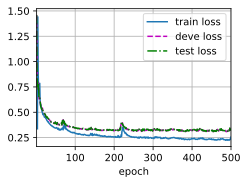

In [ ]:
train_model(net,ModuleDatasets["0.1.training"],ModuleDatasets["0.1.development"],ModuleDatasets["0.1.test"],500,0.01,[torch.device("cuda:1")],batch_size=900)

In [14]:
# 确定了最后一种模型最好
# 下面使用有实际意义的损失函数计算

train loss 0.057714810, deve loss 0.063432984, test loss 0.064894505
4.4 examples/sec on [device(type='cuda', index=1)]


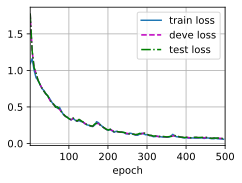

In [20]:
train_model(net,ModuleDatasets["0.1.training"],ModuleDatasets["0.1.development"],ModuleDatasets["0.1.test"],500,0.01,[torch.device("cuda:1")],batch_size=900)

train loss 0.103386637, deve loss 0.099867063, test loss 0.102252297
0.5 examples/sec on [device(type='cuda', index=3)]


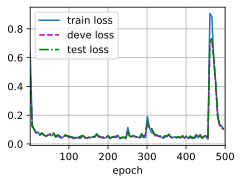

In [24]:
train_model(net,ModuleDatasets["0.05.training"],ModuleDatasets["0.05.development"],ModuleDatasets["0.05.test"],500,0.01,[torch.device("cuda:3")],batch_size=100)

train loss 0.036463015, deve loss 0.034069868, test loss 0.034916440
0.5 examples/sec on [device(type='cuda', index=3)]


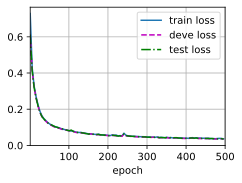

In [25]:
train_model(net,ModuleDatasets["0.1.training"],ModuleDatasets["0.1.development"],ModuleDatasets["0.1.test"],500,0.001,[torch.device("cuda:3")],batch_size=100)

train loss 2.000000000, deve loss 2.000000000, test loss 2.000000000
0.5 examples/sec on [device(type='cuda', index=2)]


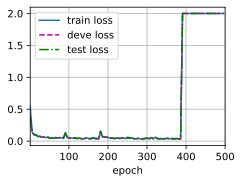

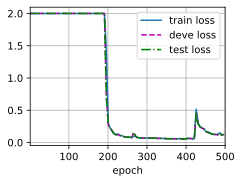

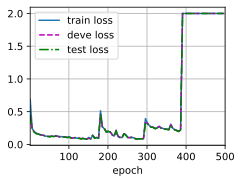

In [26]:
for height in heights:
    train_model(net,ModuleDatasets[str(height)+".training"],ModuleDatasets[str(height)+".development"],ModuleDatasets[str(height)+".test"],500,0.005,[torch.device("cuda:2")],batch_size=100)